# Exercise 3 Solution: Two-Strain Model (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/solutions/r-colab/exercise_3_two_strains.ipynb)

Model the emergence of a more transmissible variant using a multi-strain SIR model, using R via the `reticulate` package.

In [1]:
!pip install epydemix
%load_ext rpy2.ipython

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_vendor/packaging/version.py", line 56, in parse
    return Version(version)
  File "/opt/anaconda3/lib/python3.8/site-packages

In [2]:
%%R
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


## Model Structure

**Compartments:** S, I1, I2, R1, R2

**Transitions:**
- S + I1 → 2I1 (rate β)
- S + I2 → 2I2 (rate β·ψ, where ψ > 1)
- R1 + I2 → I2 + R2 (rate β·ψ·γ, partial cross-immunity)
- I1 → R1 (rate μ)
- I2 → R2 (rate μ)

## Task 1: Implement the Two-Strain Model

In [3]:
%%R
# Import epydemix
epydemix <- import("epydemix")
EpiModel <- epydemix$EpiModel
builtins <- import_builtins()
np <- import("numpy")
viz <- import("epydemix.visualization")
plot_quantiles <- viz$plot_quantiles

# Function to create a two-strain model
create_two_strain_model <- function(psi = 1.5, gamma_val = 0.4, beta = 0.20, mu = 0.1) {
  model <- EpiModel(name = "Two-Strain SIR", compartments = c("S", "I1", "I2", "R1", "R2"))
  
  # S + I1 -> 2I1
  params_S_I1 <- builtins$tuple(list("beta", "I1"))
  model$add_transition(source = "S", target = "I1", kind = "mediated", params = params_S_I1)
  
  # S + I2 -> 2I2 (more transmissible)
  params_S_I2 <- builtins$tuple(list("beta*psi", "I2"))
  model$add_transition(source = "S", target = "I2", kind = "mediated", params = params_S_I2)
  
  # R1 + I2 -> I2 + R2 (reinfection)
  params_R1_I2 <- builtins$tuple(list("beta*psi*gamma", "I2"))
  model$add_transition(source = "R1", target = "I2", kind = "mediated", params = params_R1_I2)
  
  # I1 -> R1
  model$add_transition(source = "I1", target = "R1", kind = "spontaneous", params = "mu1")
  
  # I2 -> R2
  model$add_transition(source = "I2", target = "R2", kind = "spontaneous", params = "mu2")
  
  # Set parameters
  model$add_parameter("beta", beta)
  model$add_parameter("psi", psi)
  model$add_parameter("gamma", gamma_val)
  model$add_parameter("mu1", mu)
  model$add_parameter("mu2", mu)
  
  return(model)
}

# Create the model
model <- create_two_strain_model(psi = 1.5, gamma_val = 0.4)
model

EpiModel(name='Two-Strain SIR')
Compartments: 5
  S, I1, I2, R1, R2
Transitions: 5
  Transitions between compartments:
    S -> I1, params: ['beta', 'I1'] (kind: mediated)
    S -> I2, params: ['beta*psi', 'I2'] (kind: mediated)
    R1 -> I2, params: ['beta*psi*gamma', 'I2'] (kind: mediated)
    I1 -> R1, params: mu1 (kind: spontaneous)
    I2 -> R2, params: mu2 (kind: spontaneous)
Parameters: 5
  Model parameters:
    beta: 0.2
    psi: 1.5
    gamma: 0.4
    mu1: 0.1
    mu2: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



## Task 2: Delay Strain 2 Emergence

We use `override_parameter` to set ψ=0 and μ2=0 for the first 30 days, effectively turning off strain 2.

In [4]:
%%R
# Override parameters to delay strain 2 emergence
model$override_parameter(
  start_date = "2025-01-01",
  end_date = "2025-01-31",
  parameter_name = "psi",
  value = 0.0
)

model$override_parameter(
  start_date = "2025-01-01",
  end_date = "2025-01-31",
  parameter_name = "mu2",
  value = 0.0
)

## Task 3: Simulate and Visualize

In [5]:
%%R
# Get default population Nk
Nk_val <- py_to_r(model$population$Nk)

# Initial conditions
initial_conditions <- reticulate::dict(
  S = np$array(as.integer(Nk_val - 20)),
  I1 = np$array(as.integer(10)),
  I2 = np$array(as.integer(10)),
  R1 = np$array(as.integer(0)),
  R2 = np$array(as.integer(0))
)

# Run simulations
results <- model$run_simulations(
  start_date = "2025-01-01",
  end_date = "2025-07-31",
  Nsim = 50L,
  initial_conditions_dict = initial_conditions
)

<Axes: title={'center': 'Two-Strain Dynamics: Emergence of a More Transmissible Variant'}, ylabel='Infected'>


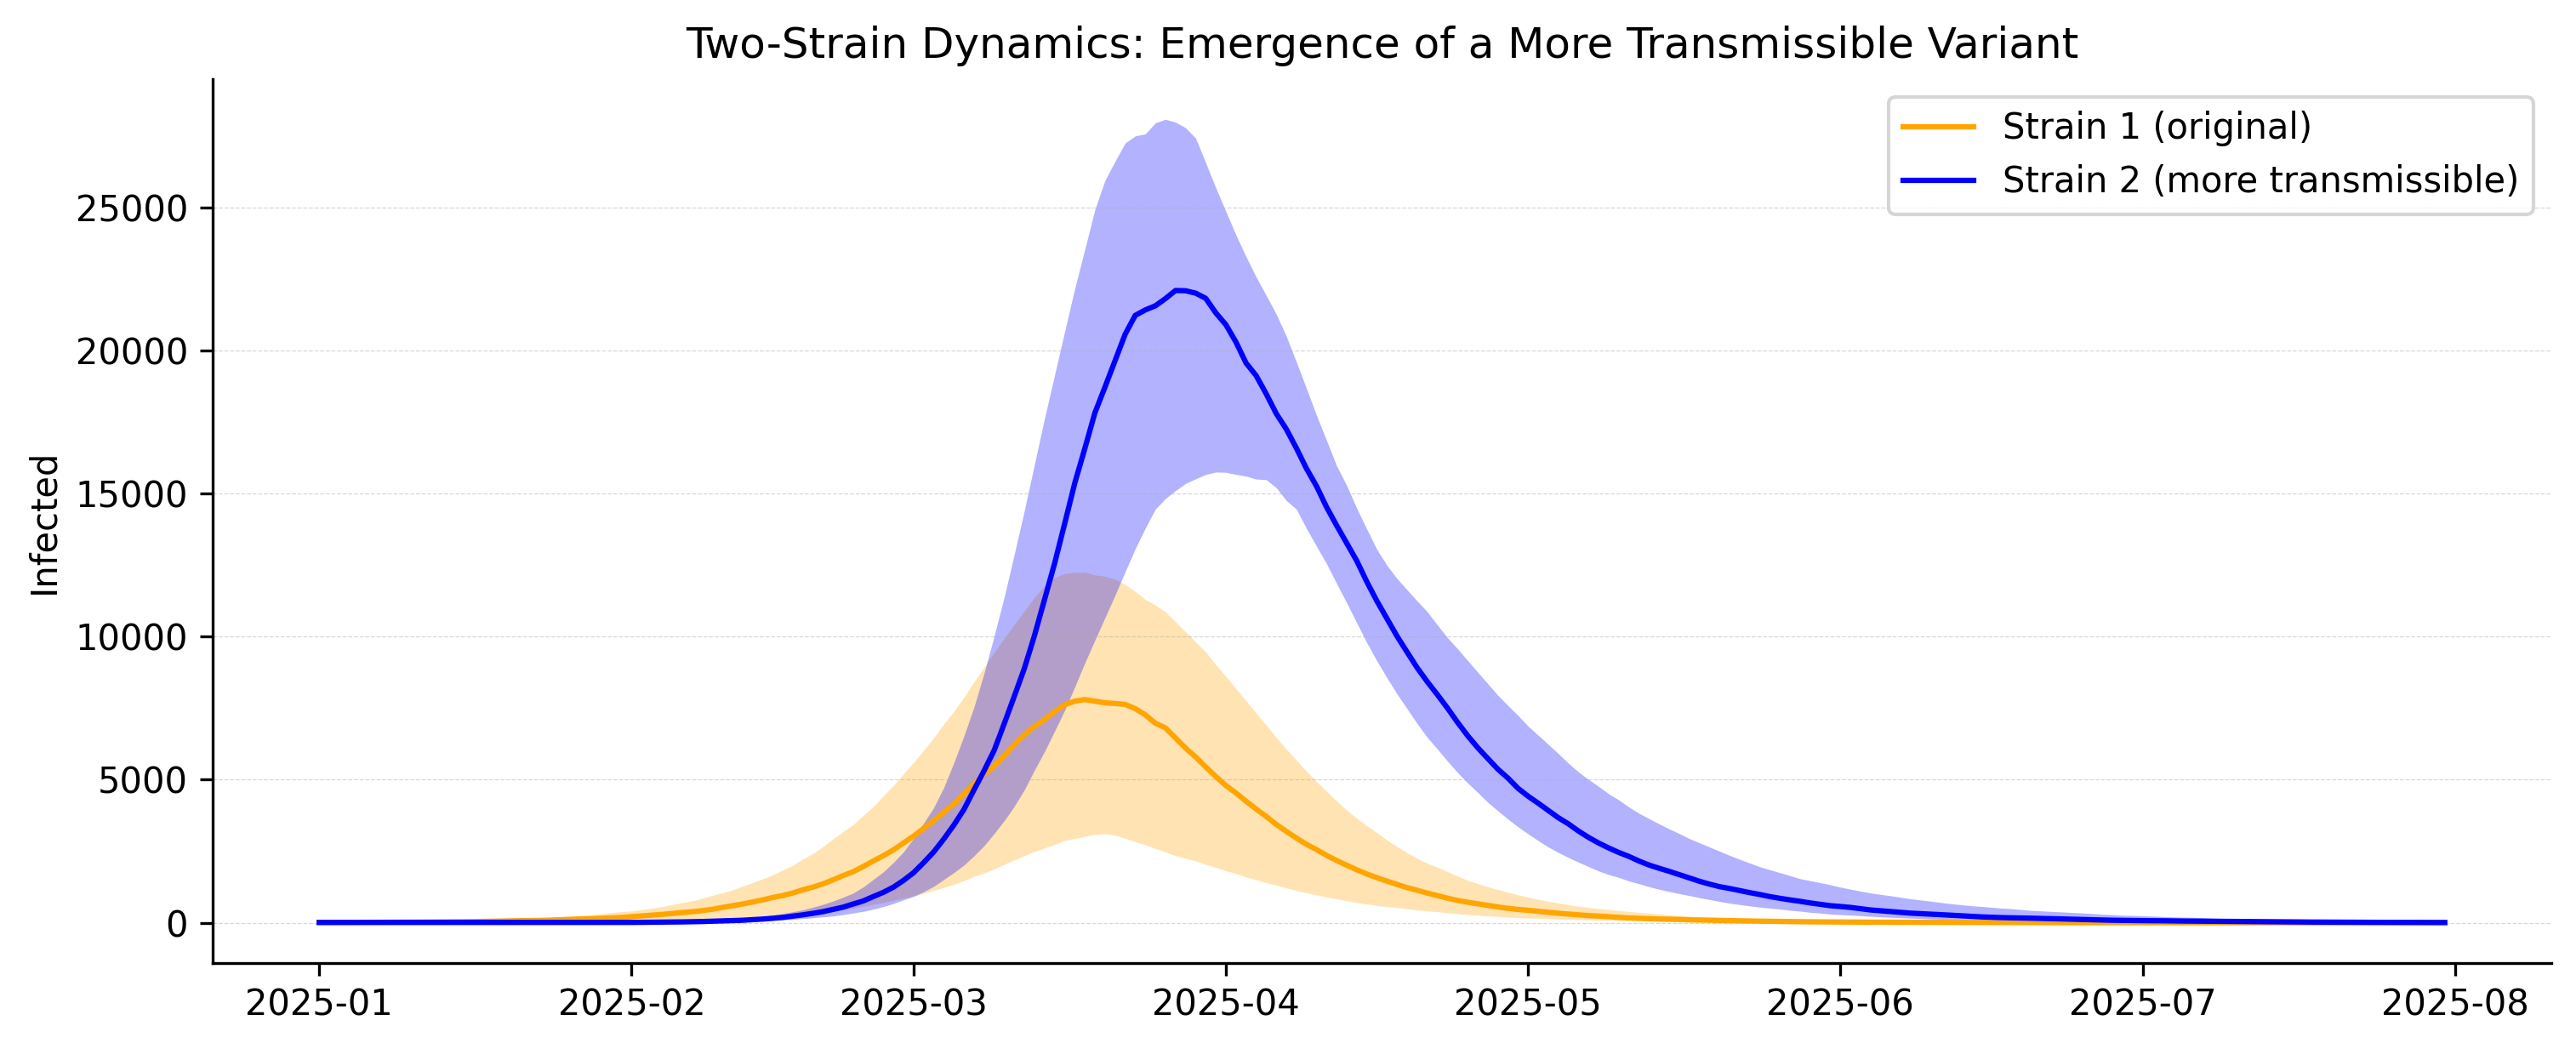

In [6]:
%%R
# Plot both strains
df_quantiles <- results$get_quantiles_compartments()

ax <- plot_quantiles(df_quantiles, columns = c("I1_total"),
                     colors = "orange", labels = list("Strain 1 (original)"))
ax <- plot_quantiles(df_quantiles, columns = c("I2_total"),
                     colors = "blue", labels = list("Strain 2 (more transmissible)"), ax = ax)

ax$set_title("Two-Strain Dynamics: Emergence of a More Transmissible Variant")
ax$set_ylabel("Infected")
ax$legend()
ax

## Task 4: Experiments

### Experiment A: Effect of Emergence Timing

In [7]:
%%R
run_with_emergence_day <- function(emergence_day) {
  m <- create_two_strain_model(psi = 1.5, gamma_val = 0.4)
  
  emergence_date <- as.character(as.Date("2025-01-01") + emergence_day)
  
  m$override_parameter(
    start_date = "2025-01-01", end_date = emergence_date,
    parameter_name = "psi", value = 0.0
  )
  m$override_parameter(
    start_date = "2025-01-01", end_date = emergence_date,
    parameter_name = "mu2", value = 0.0
  )
  
  Nk_val <- py_to_r(m$population$Nk)
  ic <- reticulate::dict(
    S = np$array(as.integer(Nk_val - 20)),
    I1 = np$array(as.integer(10)),
    I2 = np$array(as.integer(10)),
    R1 = np$array(as.integer(0)),
    R2 = np$array(as.integer(0))
  )
  
  res <- m$run_simulations(
    start_date = "2025-01-01", end_date = "2025-07-31",
    Nsim = 50L, initial_conditions_dict = ic
  )
  
  list(results = res, emergence_date = emergence_date)
}

# Run with different emergence times
res_early <- run_with_emergence_day(15)
res_mid <- run_with_emergence_day(30)
res_late <- run_with_emergence_day(45)

<Axes: title={'center': 'Early emergence (day 15)'}>


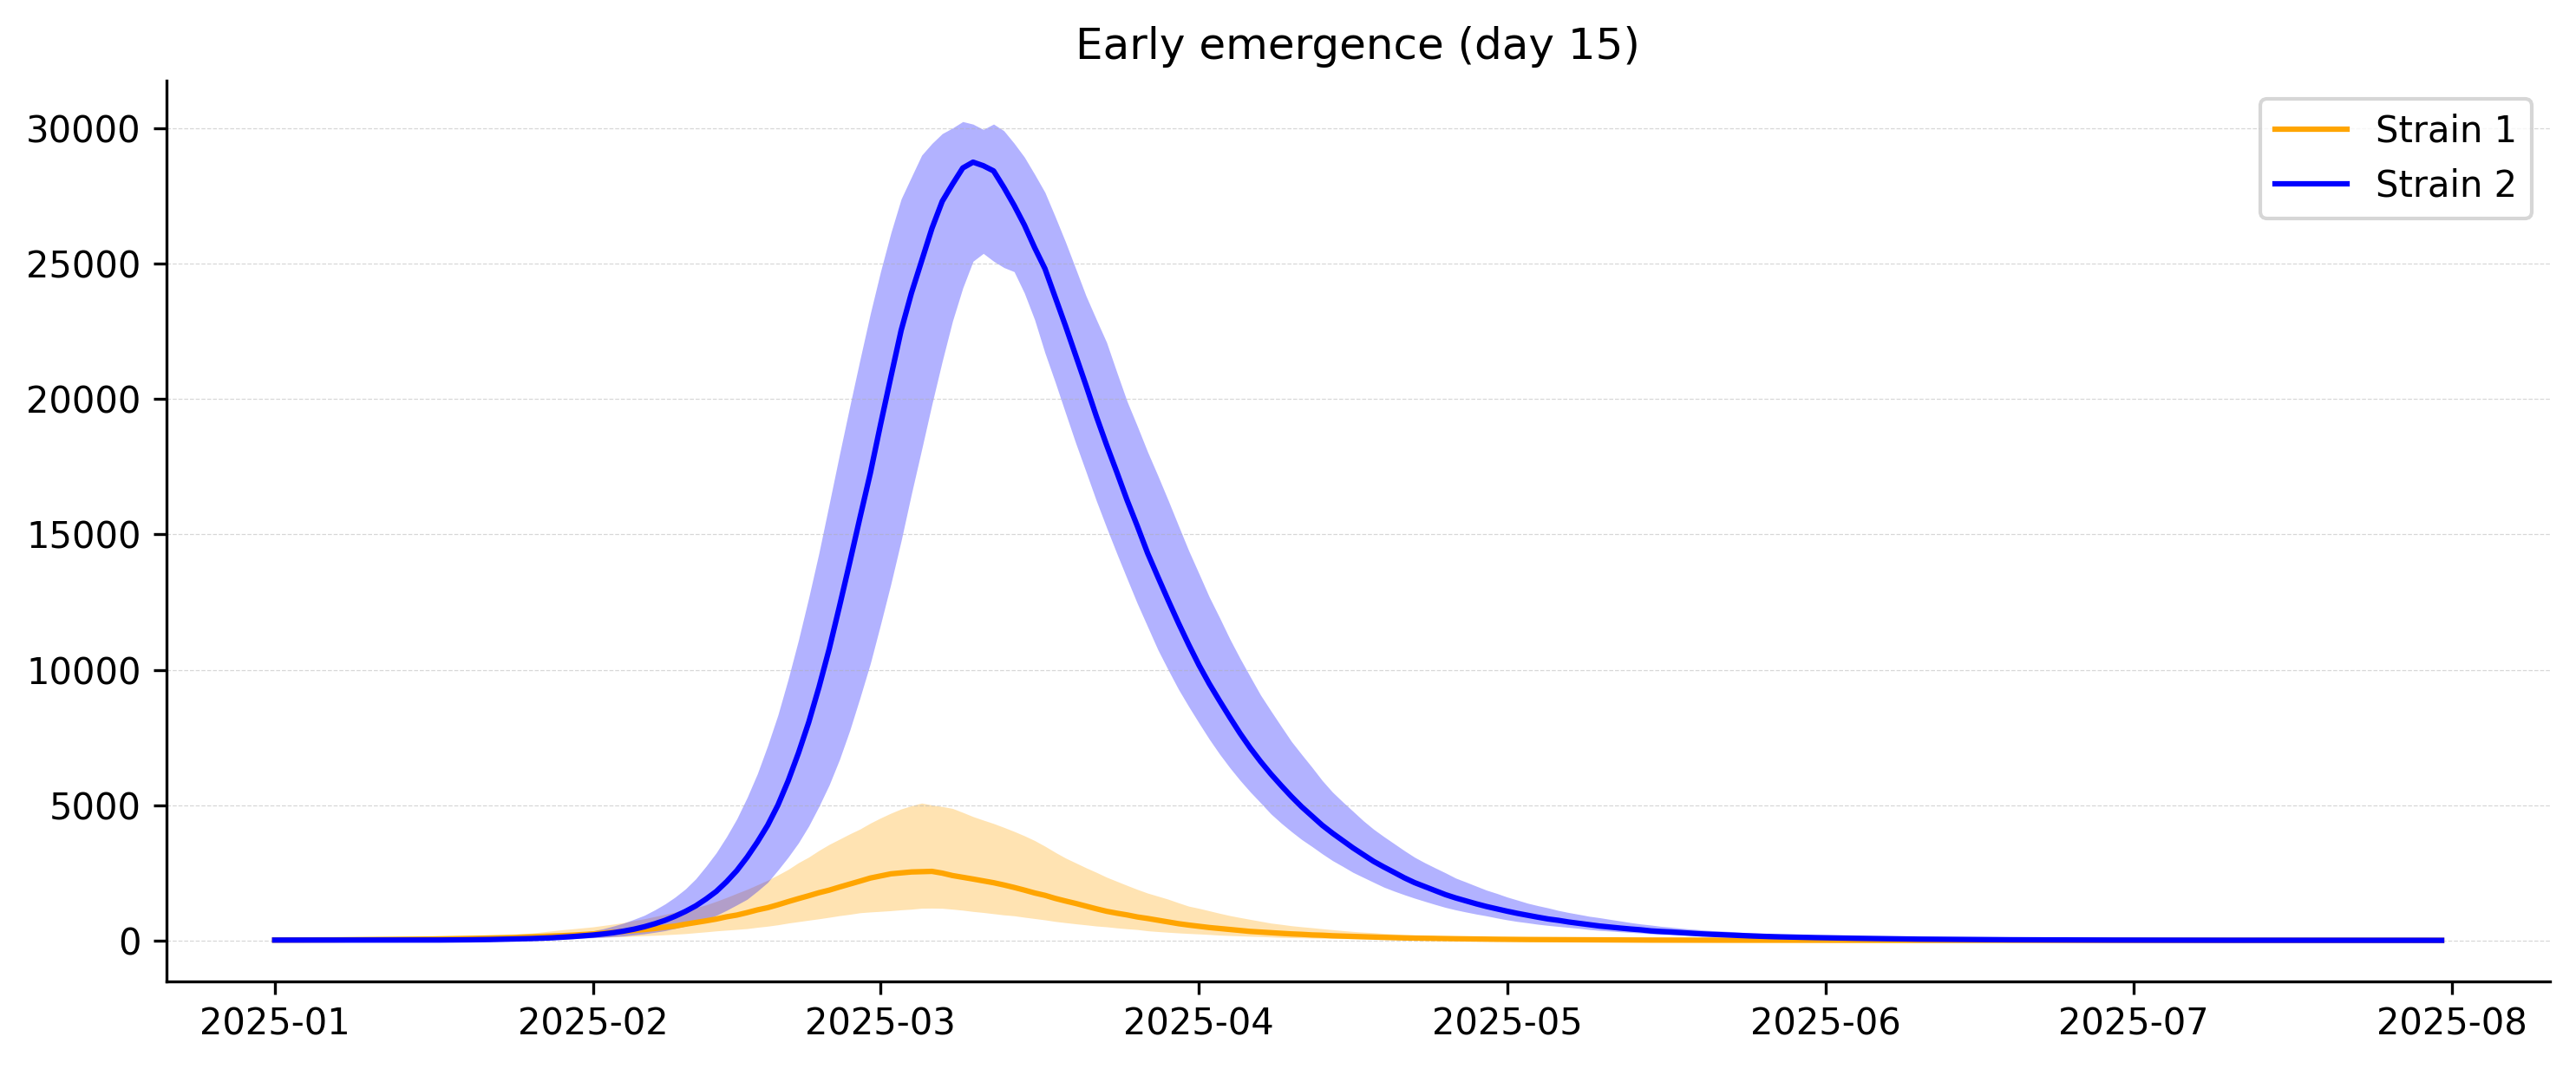

In [8]:
%%R

# Plot early emergence
df <- res_early$results$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title("Early emergence (day 15)")
ax$legend()
ax

<Axes: title={'center': 'Mid emergence (day 30)'}>


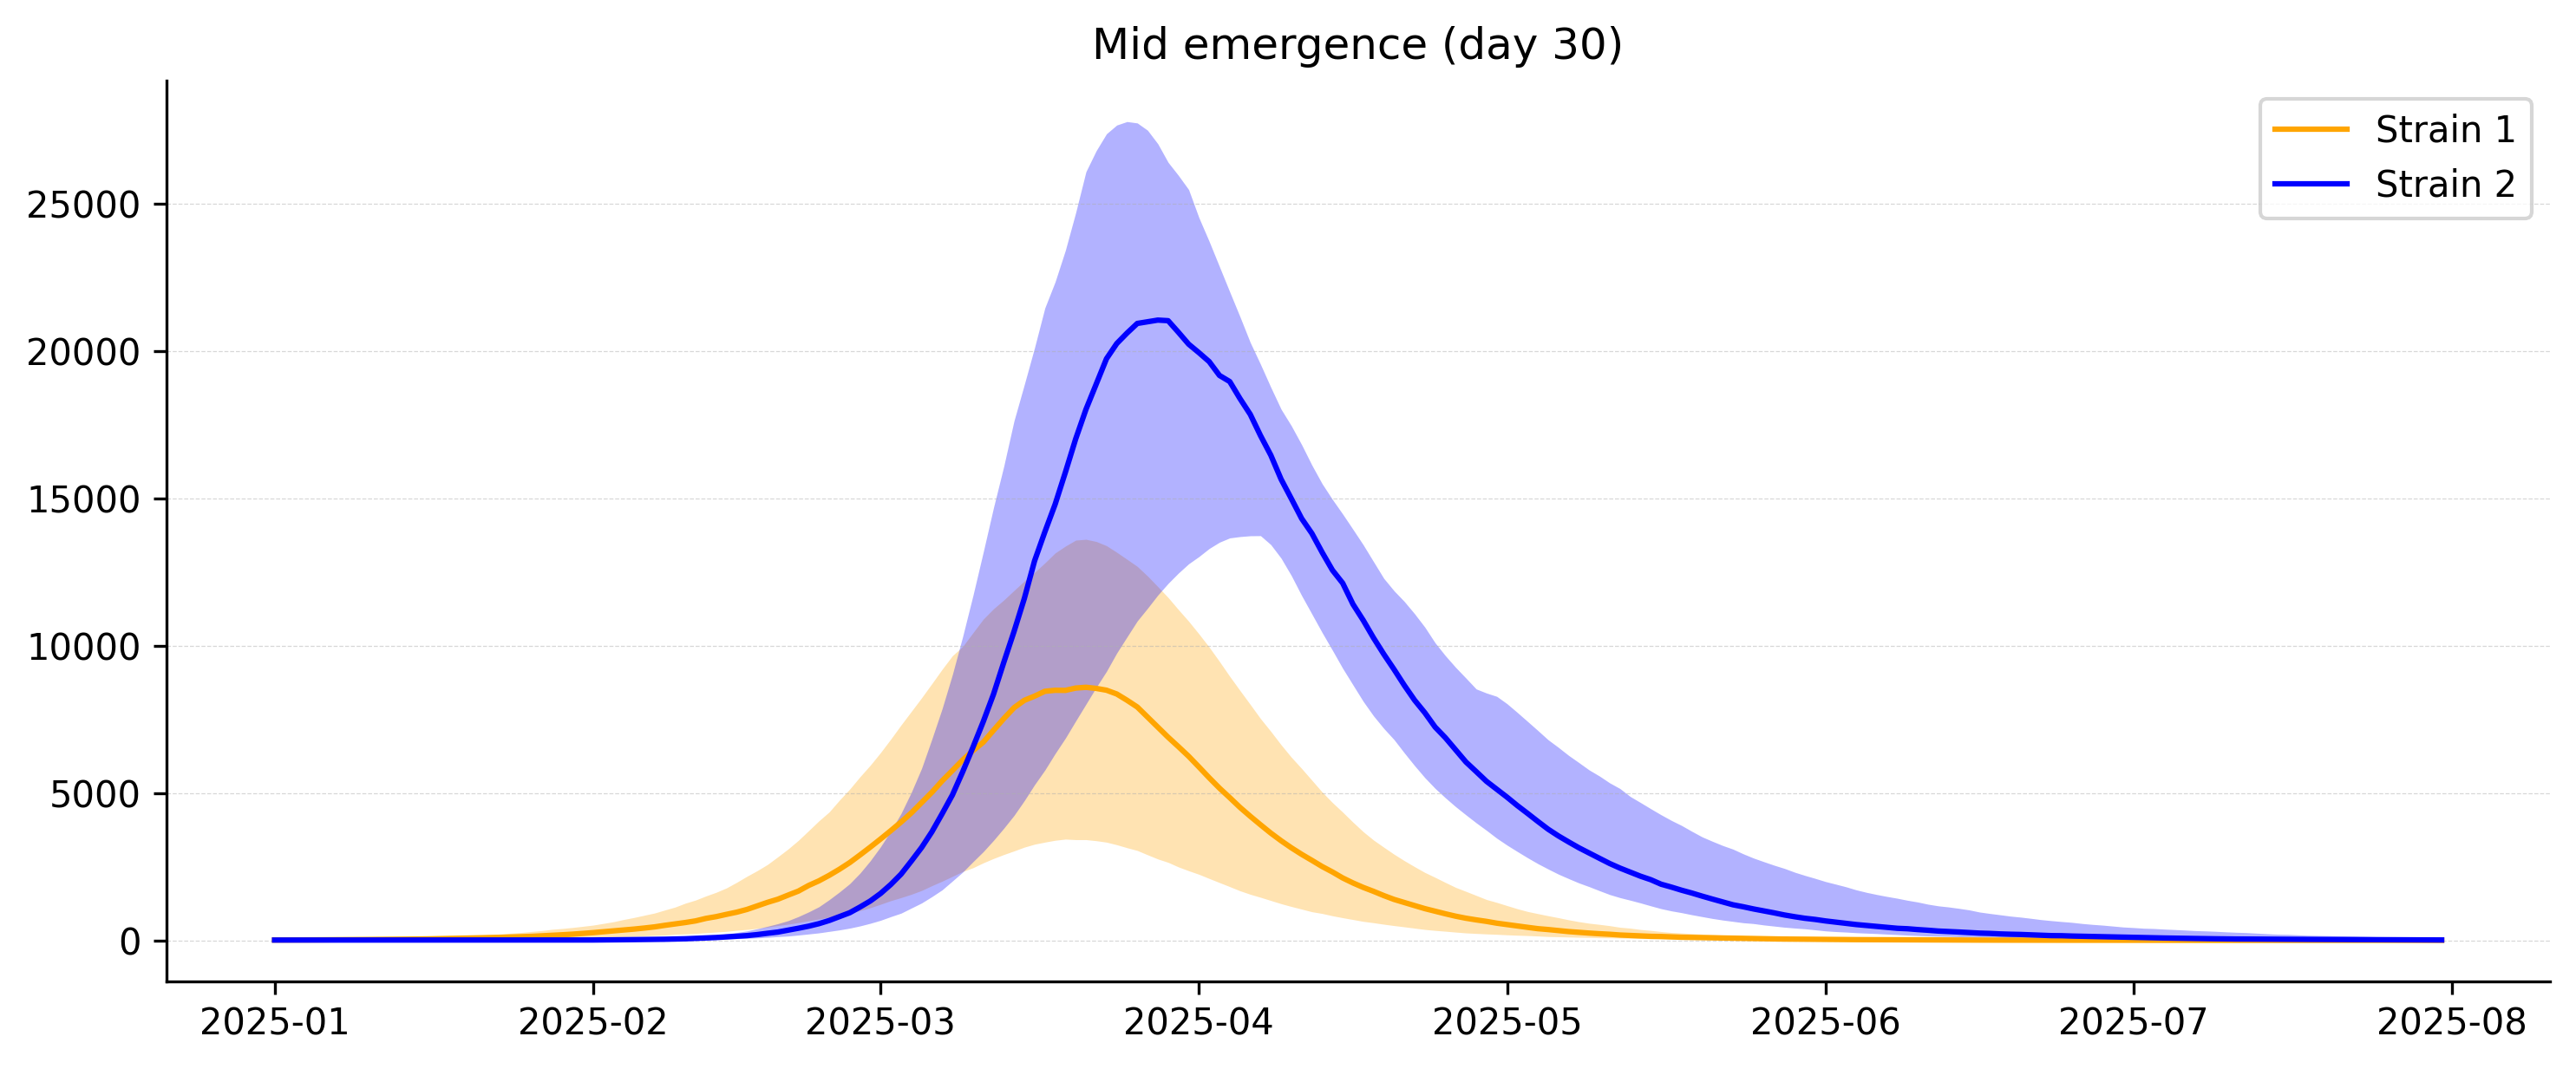

In [9]:
%%R

# Plot early emergence
df <- res_mid$results$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title("Mid emergence (day 30)")
ax$legend()
ax

<Axes: title={'center': 'Late emergence (day 45)'}>


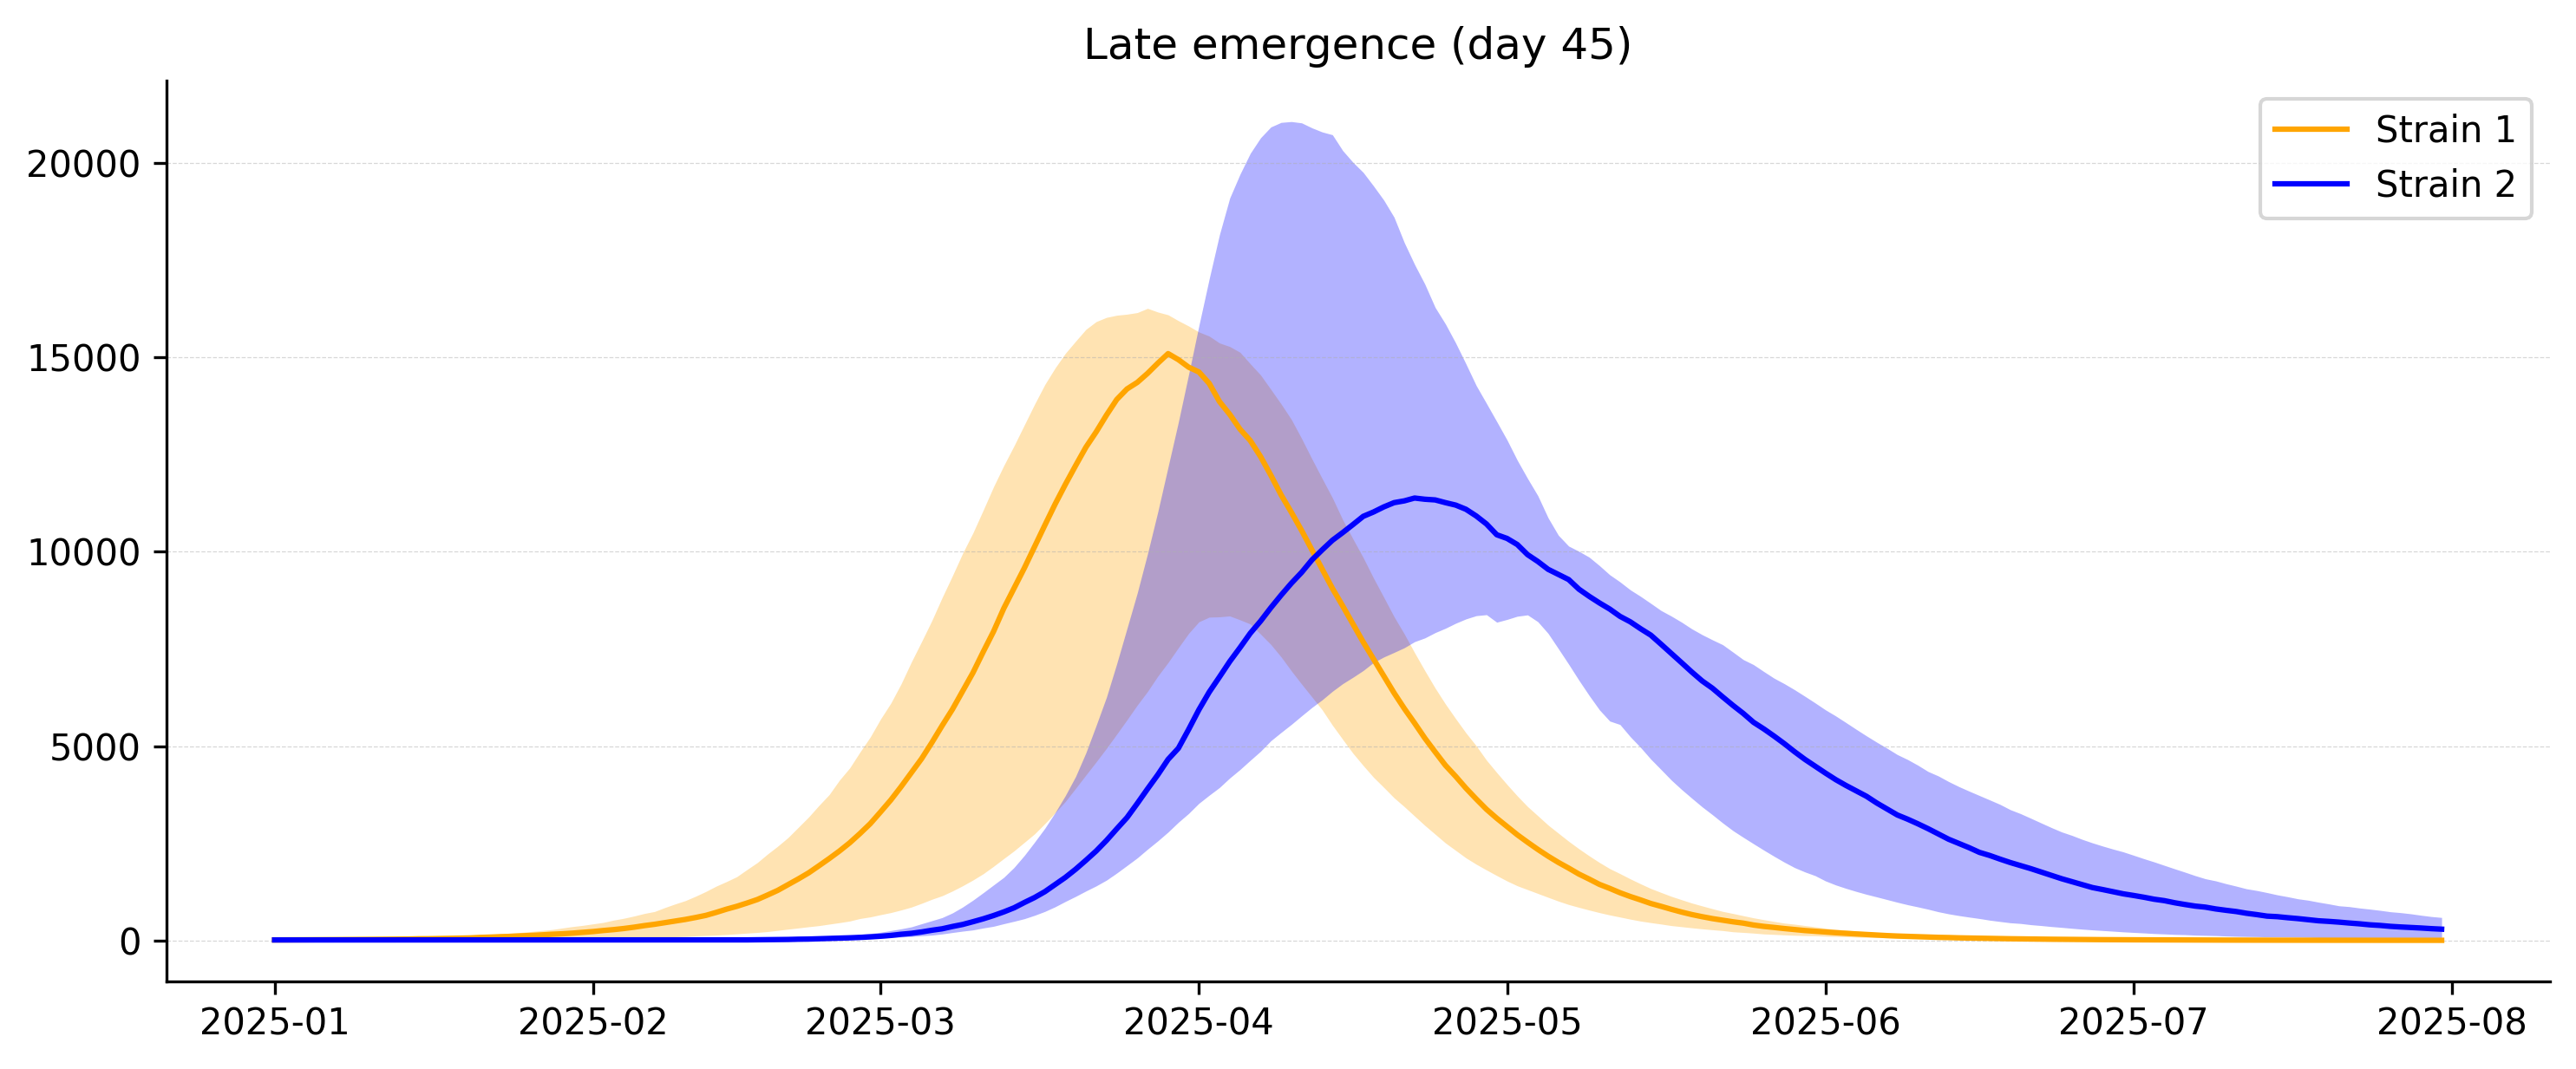

In [10]:
%%R
# Plot late emergence
df <- res_late$results$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title("Late emergence (day 45)")
ax$legend()
ax

### Experiment B: Effect of Transmissibility Advantage

In [11]:
%%R
run_with_psi <- function(psi_value) {
  m <- create_two_strain_model(psi = psi_value, gamma_val = 0.4)
  
  m$override_parameter(
    start_date = "2025-01-01", end_date = "2025-01-31",
    parameter_name = "psi", value = 0.0
  )
  m$override_parameter(
    start_date = "2025-01-01", end_date = "2025-01-31",
    parameter_name = "mu2", value = 0.0
  )
  
  Nk_val <- py_to_r(m$population$Nk)
  ic <- reticulate::dict(
    S = np$array(as.integer(Nk_val - 20)),
    I1 = np$array(as.integer(10)),
    I2 = np$array(as.integer(10)),
    R1 = np$array(as.integer(0)),
    R2 = np$array(as.integer(0))
  )
  
  m$run_simulations(
    start_date = "2025-01-01", end_date = "2025-07-31",
    Nsim = 50L, initial_conditions_dict = ic
  )
}

results_psi_low <- run_with_psi(1.2)
results_psi_mid <- run_with_psi(1.5)
results_psi_high <- run_with_psi(2.0)

<Axes: title={'center': '<capsule object "r_object" at 0x7f8f4516ff30>'}>


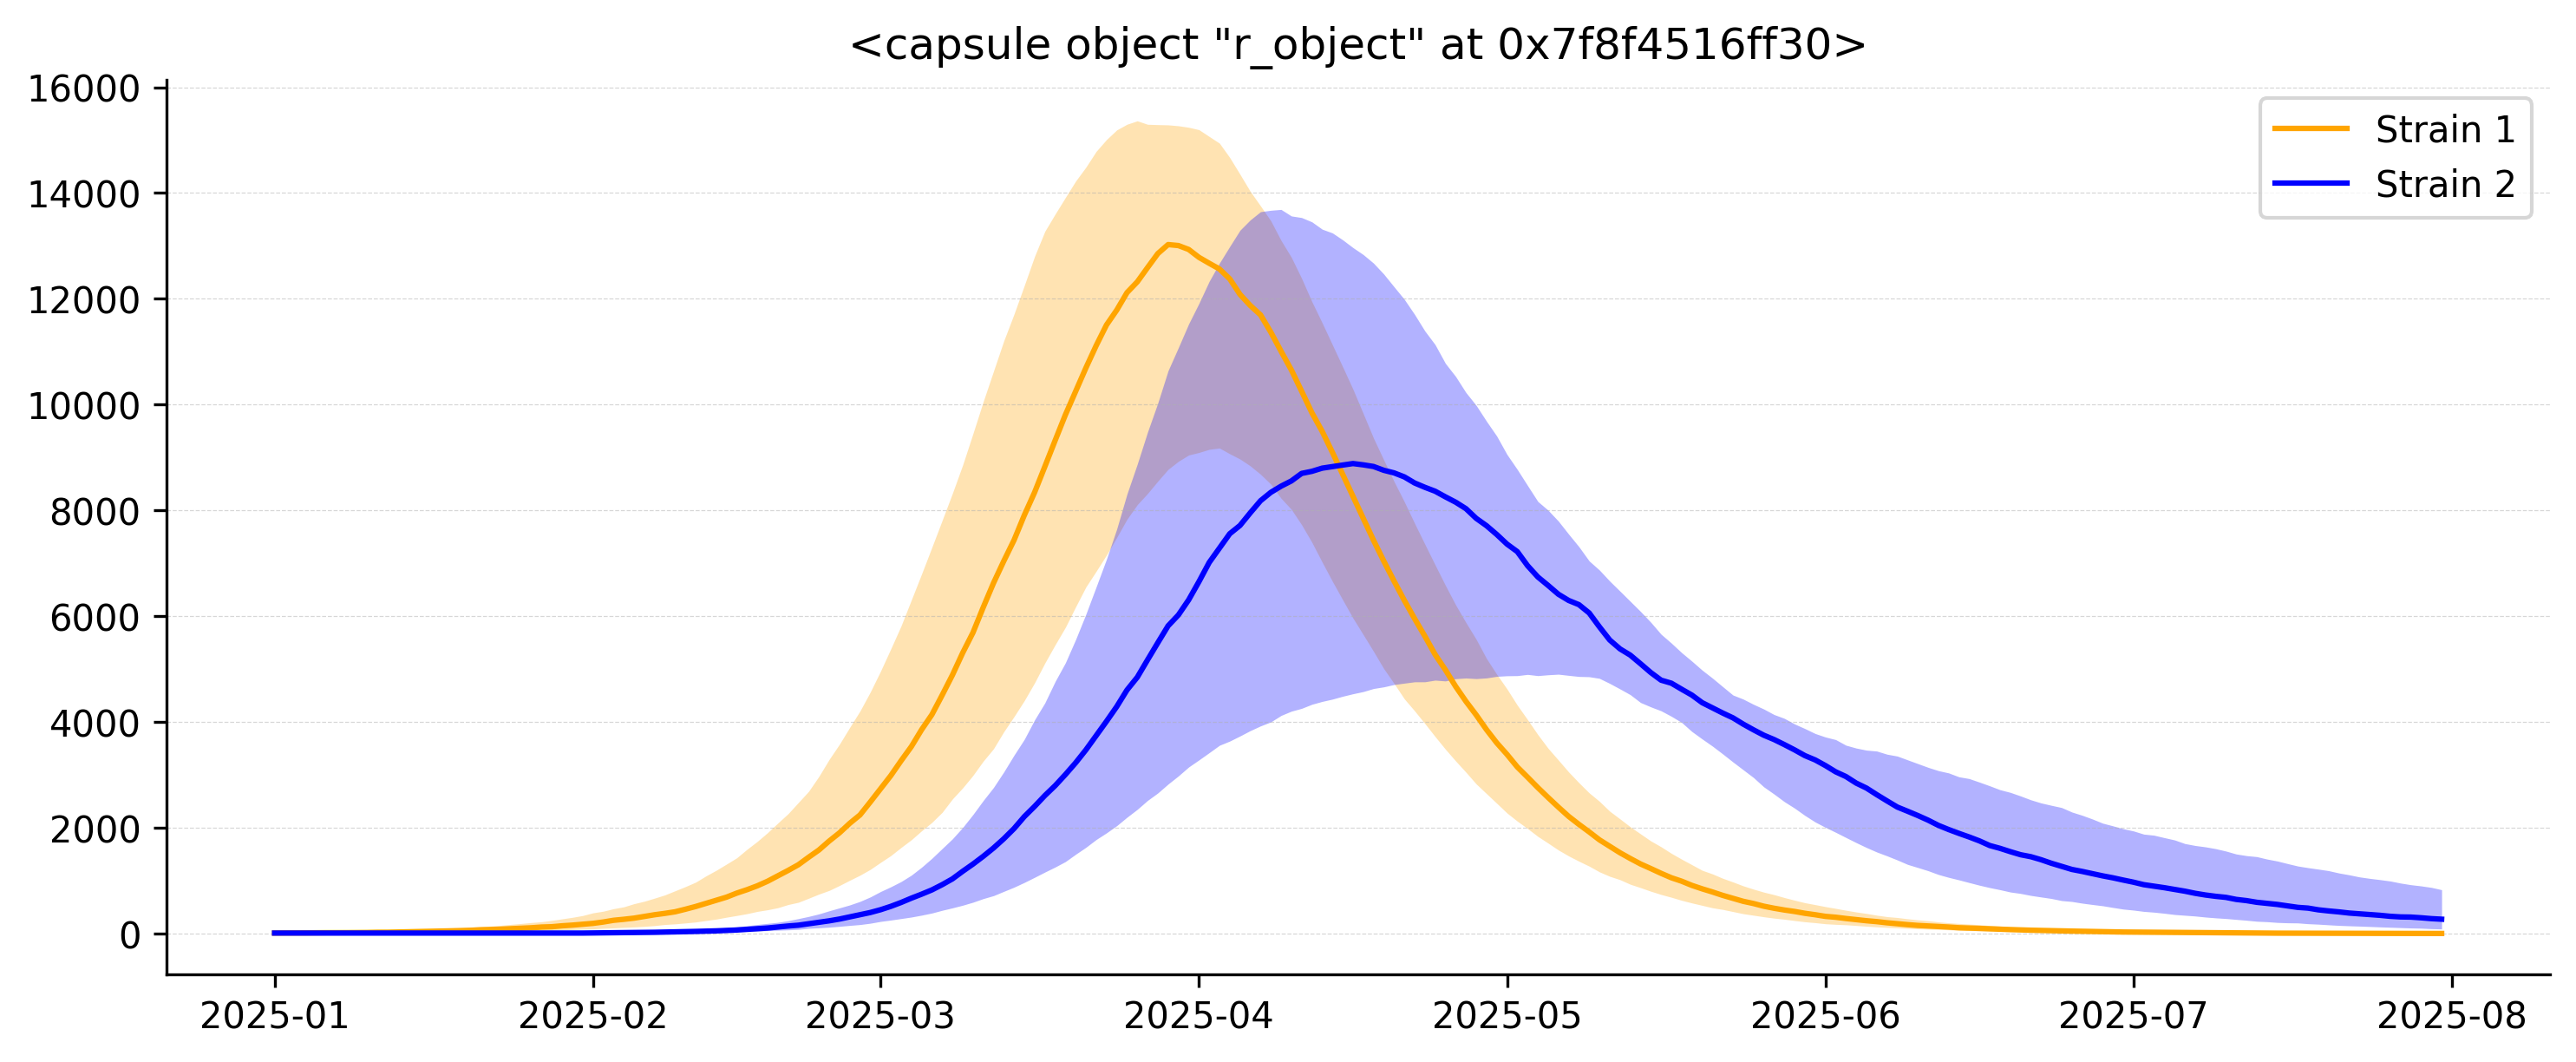

In [12]:
%%R
# Plot psi = 1.2
df <- results_psi_low$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title(expression(paste(psi, " = 1.2 (20% advantage)")))
ax$legend()
ax

<Axes: title={'center': '<capsule object "r_object" at 0x7f8f2fbec330>'}>


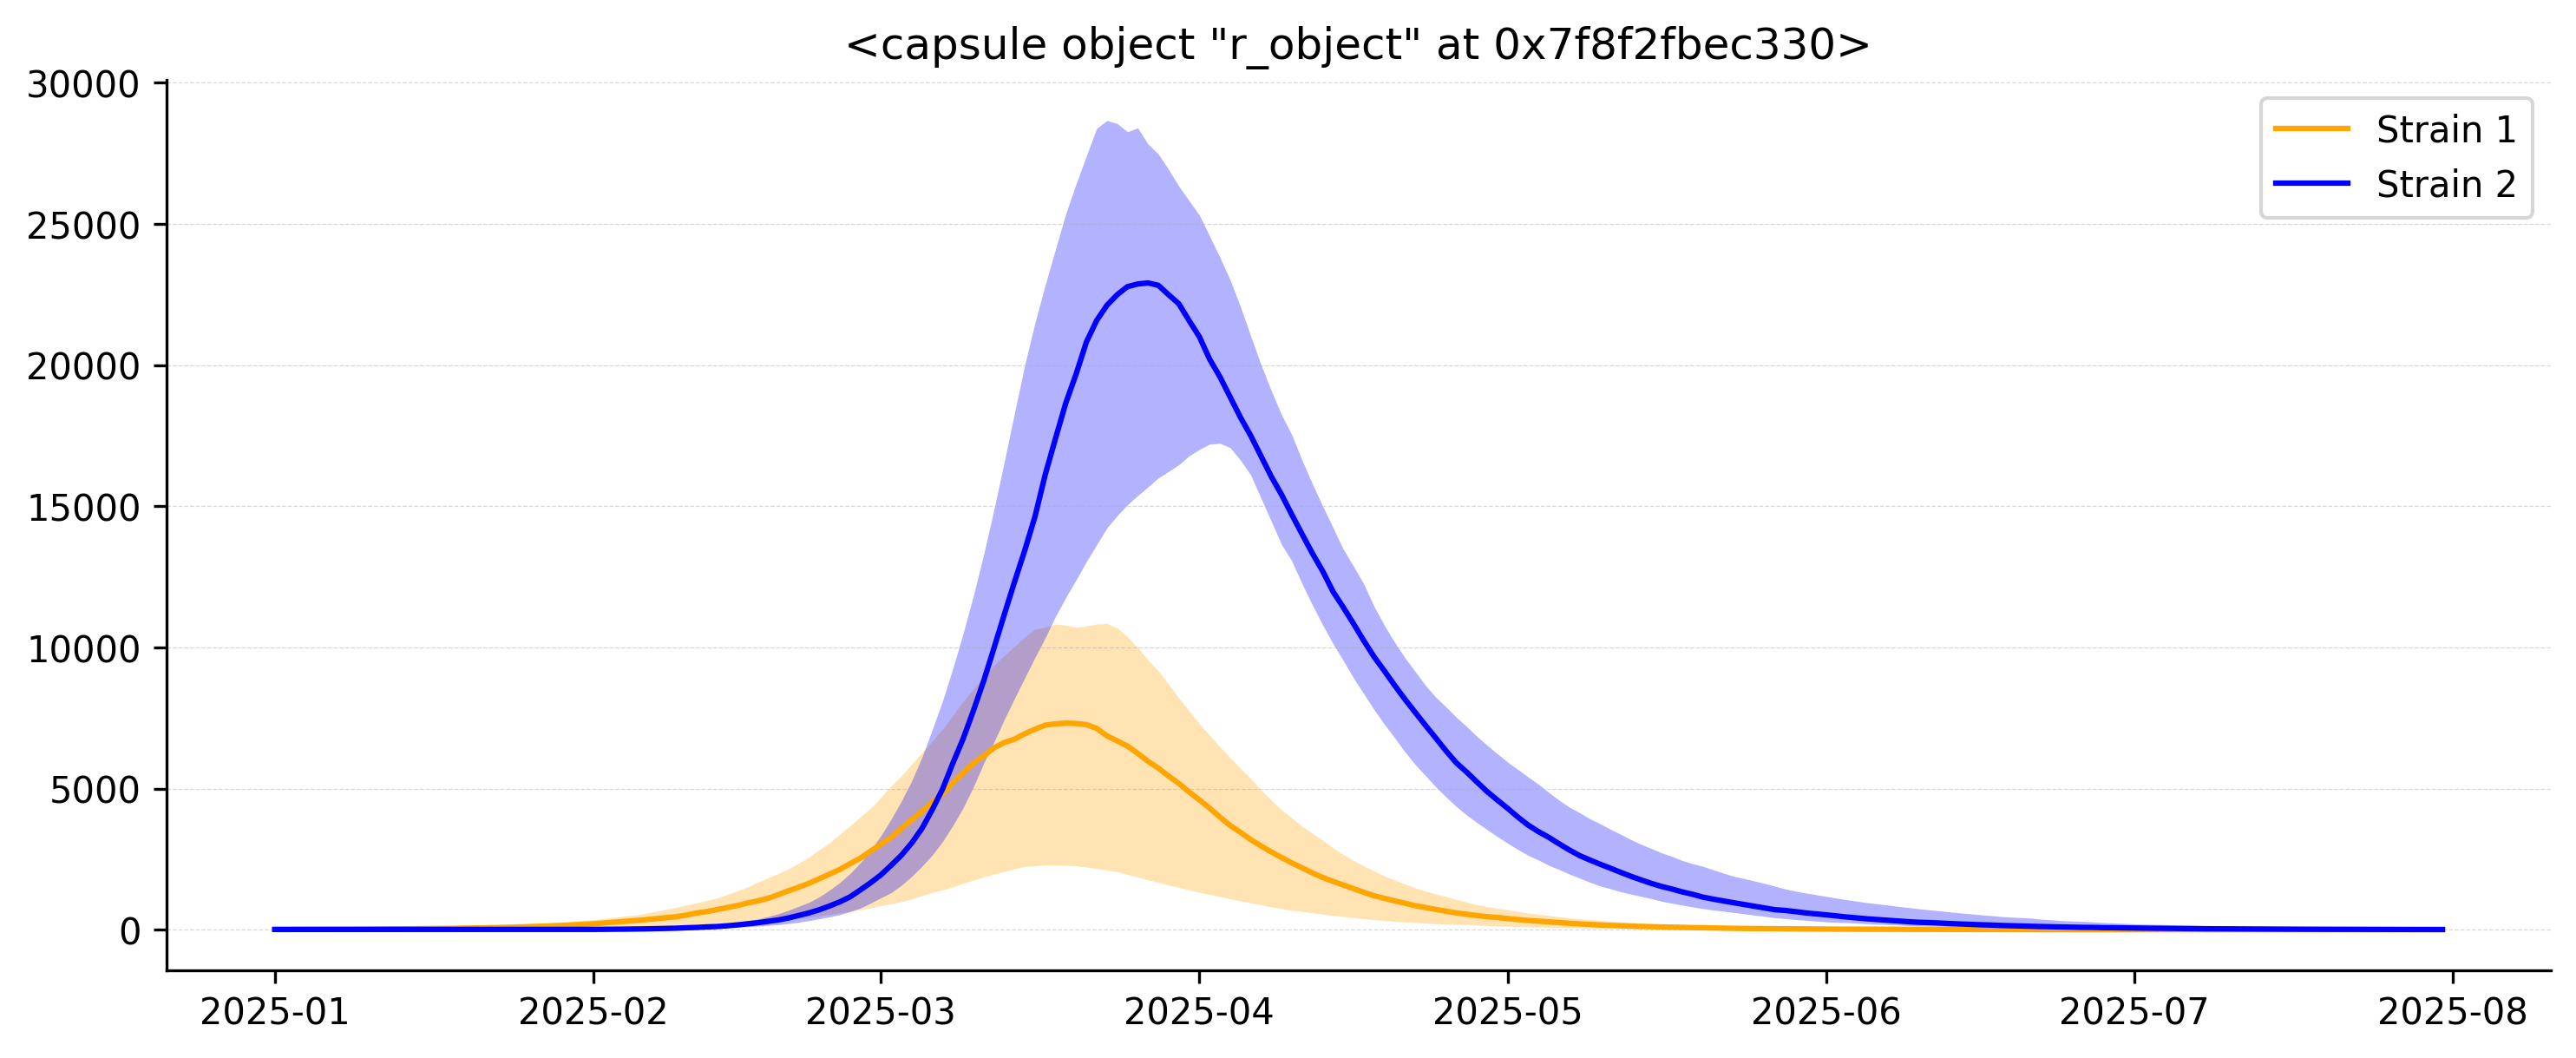

In [13]:
%%R
# Plot psi = 1.5
df <- results_psi_mid$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title(expression(paste(psi, " = 1.5 (50% advantage)")))
ax$legend()
ax

<Axes: title={'center': '<capsule object "r_object" at 0x7f8f2fe0e660>'}>


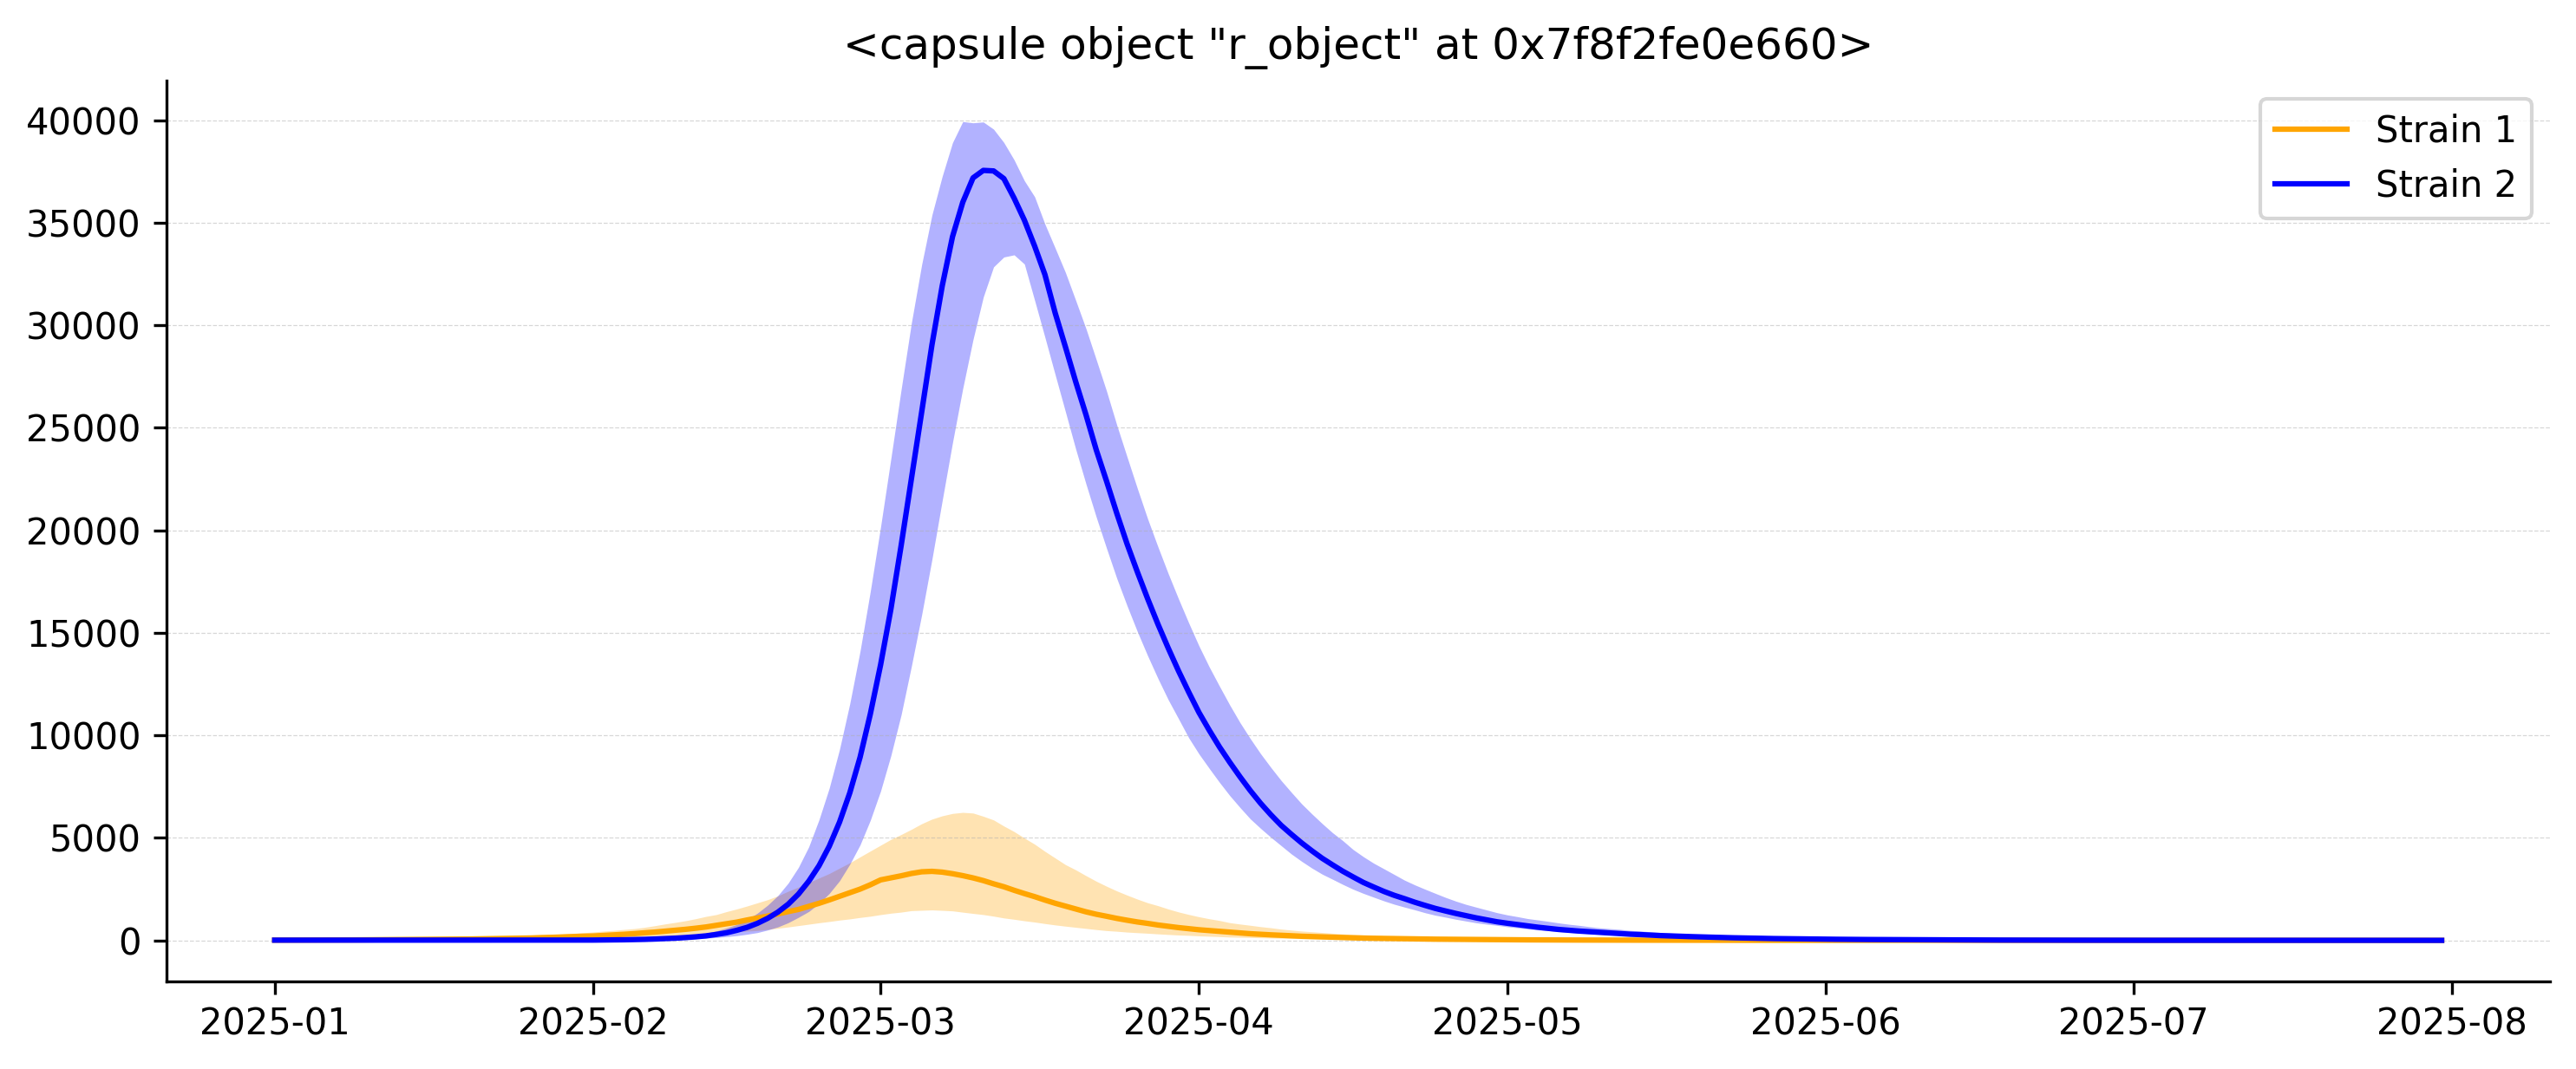

In [14]:
%%R
# Plot psi = 2.0
df <- results_psi_high$get_quantiles_compartments()
ax <- plot_quantiles(df, columns = c("I1_total"), colors = "orange", labels = list("Strain 1"))
ax <- plot_quantiles(df, columns = c("I2_total"), colors = "blue", labels = list("Strain 2"), ax = ax)
ax$set_title(expression(paste(psi, " = 2.0 (100% advantage)")))
ax$legend()
ax

In [15]:
%%R
# Compute dominance day
compute_dominance_day <- function(results) {
  traj <- results$get_stacked_compartments()
  I1_median <- apply(py_to_r(traj["I1_total"])$I1_total, 2, median)
  I2_median <- apply(py_to_r(traj["I2_total"])$I2_total, 2, median)
  
  crossover <- which(I2_median > I1_median & I2_median > 100)
  if (length(crossover) > 0) return(crossover[1])
  return(NA)
}

cat("Days until strain 2 dominance:\n")
cat(sprintf("  psi = 1.2: Day %s\n", compute_dominance_day(results_psi_low)))
cat(sprintf("  psi = 1.5: Day %s\n", compute_dominance_day(results_psi_mid)))
cat(sprintf("  psi = 2.0: Day %s\n", compute_dominance_day(results_psi_high)))

Days until strain 2 dominance:
  psi = 1.2: Day 105
  psi = 1.5: Day 66
  psi = 2.0: Day 50


## Discussion

**Key observations:**

1. **Emergence timing matters:** Early emergence allows strain 2 to take over quickly before strain 1 depletes susceptibles. Late emergence means fewer susceptibles remain, but strain 2 can still spread among R1 individuals.

2. **Transmissibility advantage (ψ):** Higher ψ leads to faster strain replacement. Even modest advantages (20%) lead to eventual dominance.

3. **Cross-immunity (γ):** γ = 0.4 means R1 individuals have 60% protection against strain 2. This slows but doesn't prevent spread.

**Real-world implications:**
- Early detection of new variants is crucial for pandemic response
- Even small transmissibility advantages compound through exponential growth
- Vaccines providing cross-variant protection can slow variant emergence